In [33]:
# Benchmark small CNN
import os
import re
from gc import callbacks

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import glob  # concise for finding files

# --- Configuration ---
SIZE = 500
BATCH_SIZE = 32
CHANNELS = 1
INPUT_SHAPE = (SIZE, SIZE, CHANNELS)


In [34]:

# --- Helper Functions ---

def load_labels(csv_path):
    df = pd.read_csv(csv_path, index_col='id')
    # skip 'male' column

    return df[['boneage']]


def create_dataframe(image_dir, labels_df):
    data = []
    # Use glob for potentially simpler file finding if needed, but os.listdir is fine
    # for filename in glob.glob(os.path.join(image_dir, '*.png')): # Example with glob
    for filename in os.listdir(image_dir):
        file_id = int(filename.split('.')[0])
        if file_id in labels_df.index:
            boneage = labels_df.loc[file_id, 'boneage']
            full_path = os.path.join(image_dir, filename)
            data.append({'file_path': full_path, 'boneage': boneage})
    return pd.DataFrame(data)


def preprocess_image(image, label):
    image = tf.image.resize(image, [SIZE, SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label  # labels are already structured


def image_label_generator(file_paths, boneage_labels):
    for path, boneage in zip(file_paths, boneage_labels):
        img_bytes = tf.io.read_file(path)
        # Ensure decoding works even if image isn't strictly PNG format but decodable
        image = tf.io.decode_image(img_bytes, channels=CHANNELS, expand_animations=False)
        # Set shape explicitly if decode_image doesn't infer it fully, needed by resize
        image.set_shape([None, None, CHANNELS])
        yield image, boneage  # Yield only boneage


def create_tf_dataset(dataframe, shuffle, repeat_flag, batch_size_local=BATCH_SIZE):
    dataset = tf.data.Dataset.from_generator(
        image_label_generator,
        args=[dataframe['file_path'].values, dataframe['boneage'].values],
        output_signature=(
            # Explicitly allow None for height/width before resizing
            tf.TensorSpec(shape=(None, None, CHANNELS), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.float32)))

    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        # Use the length of the dataframe for buffer size for effective shuffling
        dataset = dataset.shuffle(buffer_size=len(dataframe), reshuffle_each_iteration=True)

    if repeat_flag:
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size_local)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [35]:

# --- Main Data Loading and Preprocessing ---

# Correct the paths if they are relative to a specific working directory
# Assuming the script runs from a directory containing Train/, Val/, Test/
train_csv_path = os.path.join('Train', 'train_labels.csv')
val_csv_path = os.path.join('Val', 'val_labels.csv')
test_csv_path = os.path.join('Test', 'test_labels.csv')

train_image_dir = os.path.join('Train', 'train_samples_pp')
val_image_dir = os.path.join('Val', 'val_samples_pp')
test_image_dir = os.path.join('Test', 'test_samples_pp')

#Load Labels
train_labels_df = load_labels(train_csv_path)
val_labels_df = load_labels(val_csv_path)
test_labels_df = load_labels(test_csv_path)

# DataFrames linking images and labels
training_dataframe = create_dataframe(train_image_dir, train_labels_df)
validation_dataframe = create_dataframe(val_image_dir, val_labels_df)
test_dataframe = create_dataframe(test_image_dir, test_labels_df)

# tf datasets
train_dataset = create_tf_dataset(training_dataframe, shuffle=True, repeat_flag=True)
validation_dataset = create_tf_dataset(validation_dataframe, shuffle=False, repeat_flag=True)
test_dataset_eval = create_tf_dataset(test_dataframe, shuffle=False, repeat_flag=False)


In [36]:
#test
for image_batch, label_batch in train_dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)
    print("Label batch example values:", label_batch.numpy()[:5])  # Print first 5 labels

Image batch shape: (32, 500, 500, 1)
Label batch shape: (32,)
Label batch example values: [ 94.  36. 108.  96. 144.]


In [37]:
steps_per_epoch = max(1, len(training_dataframe) // BATCH_SIZE)
validation_steps = max(1, len(validation_dataframe) // BATCH_SIZE)
test_steps = max(1, len(test_dataframe) // BATCH_SIZE)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),

    # --- Quickly Reduce Resolution ---
    # Optional but recommended for speed: Add a pooling layer early
    # You could also consider resizing images beforehand (e.g., to 256x256)
    # which would be even more effective for speed.
    tf.keras.layers.MaxPooling2D((2, 2)), # Output shape: (250, 250, 1) - Halves computation early

    # --- Feature Extraction Block 1 ---
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # Removed second conv layer here for speed, can add back if needed
    tf.keras.layers.MaxPooling2D((2, 2)), # Output shape: (125, 125, 32)

    # --- Feature Extraction Block 2 ---
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)), # Output shape: (62, 62, 64) approx.

    # --- Feature Extraction Block 3 ---
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)), # Output shape: (31, 31, 128) approx.

    # --- Feature Extraction Block 4 ---
    # Kept this block, but could be removed for further speedup if needed
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # No pooling here before GAP

    # --- Transition to Dense Layers (More Efficient) ---
    # Global Average Pooling reduces each feature map to a single value
    tf.keras.layers.GlobalAveragePooling2D(), # Output shape: (256,) - MUCH smaller than Flatten

    # --- Dense Head ---
    # Fewer dense layers needed after GAP
    tf.keras.layers.Dense(128, activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.4), # Adjusted dropout slightly

    tf.keras.layers.Dense(1)  # Output layer for regression (bone age)
])



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4),
              loss='mse',
              metrics=['mae']) # mae for age prediction

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ max_pooling2d_16 (MaxPooling2D) │ (None, 250, 250, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 250, 250, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 250, 250, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 250, 250, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 31, 31, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 31, 31, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 31, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           12

 Total params: 423,297 (1.61 MB)

 Trainable params: 422,081 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [38]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min',
    verbose=1,
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, patience=2, mode='min', verbose=1)


In [39]:
history = model.fit(
    train_dataset,
    epochs=35,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping_callback, reduce_lr_callback])

Epoch 1/35
376/376 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - loss: 17248.0664 - mae: 124.7644 - val_loss: 15608.2529 - val_mae: 117.6756 - learning_rate: 4.0000e-04
Epoch 2/35
376/376 ━━━━━━━━━━━━━━━━━━━━ 376s 1000ms/step - loss: 13997.7949 - mae: 111.6358 - val_loss: 11705.1562 - val_mae: 101.1685 - learning_rate: 4.0000e-04
Epoch 3/35
376/376 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - loss: 9638.1719 - mae: 91.0943 - val_loss: 11287.1299 - val_mae: 98.7268 - learning_rate: 4.0000e-04
Epoch 4/35
376/376 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - loss: 5216.2988 - mae: 65.1494 - val_loss: 2713.3137 - val_mae: 43.8035 - learning_rate: 4.0000e-04
Epoch 5/35
376/376 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - loss: 2393.4004 - mae: 41.4931 - val_loss: 1575.8700 - val_mae: 32.7671 - learning_rate: 4.0000e-04
Epoch 6/35
376/376 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - loss: 1203.4413 - mae: 28.0194 - val_loss: 1864.9963 - val_mae: 37.2048 - learning_rate: 4.0000e-04
Epoch 7/35
376/376 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - lo

In [40]:
test_loss, test_mae = model.evaluate(test_dataset_eval, verbose=1)
print(f'error: {test_mae:.2f} months')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 801.6509 - mae: 22.5130
error: 22.35 months


C:\Users\alepa\PycharmProjects\pythonProject\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


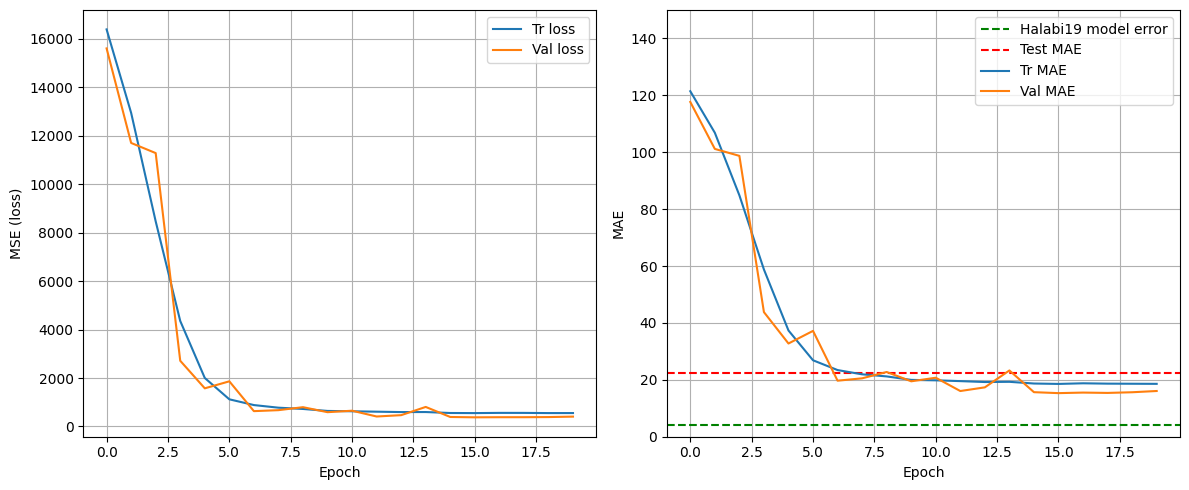

In [41]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Tr loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE (loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.ylim(0, 150)
plt.axhline(y=4, color='g', linestyle='--', label='Halabi19 model error')
plt.axhline(y=test_mae, color='r', linestyle='--', label='Test MAE')
plt.plot(history.history['mae'], label='Tr MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
